## Неделя 12. Практическое занятие по отбору признаков.

**Feature Selection (отбор признаков)** - процесс отбора подмножества признаков, наиболее релевантных к решению задачи.

Методы отбора признаков делятся на три группы:
- Filter methods (методы фильтрации)
- Embedded methods (встроенные методы)
- Wrapper methods (методы обёртки)

In [11]:
# импортируем все нужные библиотеки
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score

import seaborn as sns

In [12]:
GLOB_RAND_STATE = 0
np.random.seed(GLOB_RAND_STATE)
rng = np.random.RandomState(GLOB_RAND_STATE)

### Методы фильтрации.
**Filter methods (методы фильтрации)** для отбора используют свойства признаков, а не метрики моделей. Их плюс в лёгкости вычисления, но они часто проигрывают методам обёртки в конечном качестве моделей.

**Хи-квадрат** определяет значимую разницу между наблюдаемой и ожидаемой частотами двух категориальных переменных

In [13]:
# ссылка для скачивания датасета
# https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

In [14]:
wine_data = pd.read_csv('winequality-red.csv')

In [15]:
wine_data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [16]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(wine_data.drop('quality',axis=1),
                                                            wine_data['quality'],
                                                            test_size=0.2,
                                                            random_state=GLOB_RAND_STATE)

In [17]:
sel_k_best = SelectKBest(chi2, k=5)
sel_k_best.fit(X_train_w, y_train_w)

SelectKBest(k=5, score_func=<function chi2 at 0x00000134B9A27828>)

In [18]:
X_train_w_selected = pd.DataFrame(sel_k_best.transform(X_train_w),
                    columns=[a for a,b in zip(wine_data.columns,sel_k_best.get_support()) if b])

In [19]:
chi2_cols = X_train_w_selected.columns

In [20]:
chi2_cols

Index(['volatile acidity', 'citric acid', 'free sulfur dioxide',
       'total sulfur dioxide', 'alcohol'],
      dtype='object')

### Встроенные методы
**LASSO (L1 регуляризация)** позволяет в процессе обучения полностью занулить коэффициенты всех не влияющих на целевую переменную признаков посредством ввода штрафа на абсолютное значение коэффициента.

In [21]:
# для демонстрации работы встроенных методов сгенерируем игрушечный датасет
# с обычной линейной зависимостью y = 38*x1 + 12.5*x2 -0.7*x3 - 120*x4 + 9.05*x5 + 1.2
data = pd.DataFrame({'x1':rng.randint(0,10,1000),
                     'x2':rng.randint(0,30,1000),
                     'x3':rng.randint(0,50,1000),
                     'x4':rng.uniform(0,1,1000),
                     'x5':rng.uniform(0,1,1000)})
data['y'] = data.apply(lambda x: 38*x['x1'] + 12.5*x['x2'] - 0.7*x['x3'] - 120*x['x4'] + 9.05*x['x5'] + 1.2, axis=1)

In [22]:
# теперь зашумим второй и четвёртый признаки
data['x2'] = data['x2'].apply(lambda x: x + rng.randint(0,15,1)[0])
data['x4'] = data['x4'].apply(lambda x: x + rng.uniform(0,30,1)[0])
# добавим один мусорный признак
data['x6'] = rng.randint(0,70,1000)
# и добавим один признак, сильно коррелирующий с другим
data['x7'] = data['x1'].copy()

In [23]:
data = data[['x1','x2','x3','x4','x5','x6','x7','y']]

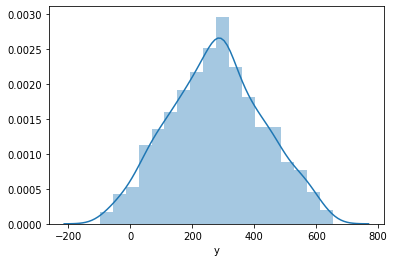

In [24]:
# посмотрим на распределение таргета
sns.distplot(data['y'])

In [25]:
# теперь поделим на трейн и тест в соотношении 80/20
# так как определять, какие признаки нужно убрать мы будем только на трейн части
X_train, X_test, y_train, y_test = train_test_split(data.drop('y',axis=1),
                                                    data['y'],
                                                    test_size=0.2,
                                                    random_state=GLOB_RAND_STATE)

In [26]:
# пеосмотрим, какие из признаков зануляются, в зависимости от кэффициентов alpha
for alpha in np.arange(1,50,5):
    print('\n Alpha = {}'.format(alpha))
    lasso = Lasso(alpha=alpha, random_state=GLOB_RAND_STATE)
    lasso.fit(X_train, y_train)
    print({a:b for a,b in zip(X_train.columns, lasso.coef_)})


 Alpha = 1
{'x1': 35.560041267419315, 'x2': 9.91151985881373, 'x3': -0.31088586042351657, 'x4': 0.2649742076710004, 'x5': -0.0, 'x6': 0.036469771704283546, 'x7': 1.9984309657915593}

 Alpha = 6
{'x1': 34.92997663066339, 'x2': 9.845158077723761, 'x3': -0.27916441514329854, 'x4': 0.19748928513042435, 'x5': -0.0, 'x6': 0.02569092453009743, 'x7': 1.973664291586401}

 Alpha = 11
{'x1': 34.29991199390747, 'x2': 9.778796296633795, 'x3': -0.24744296986308076, 'x4': 0.13000436258984793, 'x5': -0.0, 'x6': 0.014912077355911362, 'x7': 1.948897617381235}

 Alpha = 16
{'x1': 33.66984735715154, 'x2': 9.712434515543826, 'x3': -0.21572152458286292, 'x4': 0.06251944004927171, 'x5': -0.0, 'x6': 0.0041332301817252224, 'x7': 1.9241309431760838}

 Alpha = 21
{'x1': 33.039782720395614, 'x2': 9.64613961832307, 'x3': -0.18409858316466837, 'x4': 0.0, 'x5': -0.0, 'x6': 0.0, 'x7': 1.898770896150747}

 Alpha = 26
{'x1': 32.4097180836397, 'x2': 9.57879831854136, 'x3': -0.15176210789160616, 'x4': 0.0, 'x5': -0.0, '

In [27]:
# попробуем теперь обучить модель с произвольным параметром alpha и посмотреть ошибку на тесте
lasso = Lasso(alpha=1, random_state=GLOB_RAND_STATE)
lasso.fit(X_train, y_train)
print('R2 = {:.2f}'.format(r2_score(y_test.values, lasso.predict(X_test))))

R2 = 0.86


In [28]:
# а теперь обучим две линейные регрессии: на всех признаках, и на тех, коэффициенты у которых при самом большом alpha
lreg = LinearRegression()
lreg.fit(X_train, y_train)
print('R2 all features = {:.2f}'.format(r2_score(y_test.values, lreg.predict(X_test))))

zero_coef = ['x4','x5','x6','x7']
lreg = LinearRegression()
lreg.fit(X_train.drop(zero_coef, axis=1), y_train)
print('R2 non-zero = {:.2f}'.format(r2_score(y_test.values, lreg.predict(X_test.drop(zero_coef, axis=1)))))

R2 all features = 0.86
R2 non-zero = 0.86


In [29]:
# посмотрим здесь же, помогло бы нам выделение коррелирующих признаков?
data.corr()

,x1,x2,x3,x4,x5,x6,x7,y
x1,1.000000,-0.054291,0.056686,-0.026301,0.032415,0.032219,1.000000,0.680340
x2,-0.054291,1.000000,0.014474,0.002228,0.039777,-0.046708,-0.054291,0.581724
x3,0.056686,0.014474,1.000000,-0.039155,0.034876,0.006335,0.056686,0.021299
x4,-0.026301,0.002228,-0.039155,1.000000,0.003984,0.026349,-0.026301,0.000581
x5,0.032415,0.039777,0.034876,0.003984,1.000000,0.024842,0.032415,0.041266
x6,0.032219,-0.046708,0.006335,0.026349,0.024842,1.000000,0.032219,-0.001569
x7,1.000000,-0.054291,0.056686,-0.026301,0.032415,0.032219,1.000000,0.680340
y,0.680340,0.581724,0.021299,0.000581,0.041266,-0.001569,0.680340,1.000000


### Методы обёртки.

**Методы обёртки (wrapper methods)** используют обученную модель для оценки выбранного подмножества признаков. Они наиболее вычислительно сложны. 

In [30]:
# В sklearn есть реализация RFE (Recursive feature elimination) - воспользуемся ей на двух предыдущих примерах
# попробуем сначала линейную регрессию
lreg = LinearRegression()
rfe = RFE(lreg, n_features_to_select=5, step=1)

In [31]:
rfe.fit(X_train_w, y_train_w)
X_train_w_selected = pd.DataFrame(rfe.transform(X_train_w),
                    columns=[a for a,b in zip(wine_data.columns,rfe.get_support()) if b])

In [32]:
rfe_w_cols_lreg = X_train_w_selected.columns

In [33]:
rfe_w_cols_lreg

Index(['volatile acidity', 'chlorides', 'density', 'pH', 'sulphates'], dtype='object')

In [34]:
# теперь для данных с линейной функцией
lreg = LinearRegression()
rfe = RFE(lreg, n_features_to_select=5, step=1)

In [35]:
rfe.fit(X_train, y_train)
X_train_selected = pd.DataFrame(rfe.transform(X_train),
                    columns=[a for a,b in zip(data.columns,rfe.get_support()) if b])

In [36]:
X_train_selected

,x1,x2,x3,x5,x7
0,6.0,22.0,46.0,0.449234,6.0
1,9.0,32.0,48.0,0.002771,9.0
2,0.0,8.0,5.0,0.099908,0.0
3,0.0,16.0,16.0,0.114763,0.0
4,8.0,12.0,40.0,0.573674,8.0
...,...,...,...,...,...
795,4.0,12.0,34.0,0.630017,4.0
796,0.0,7.0,17.0,0.799730,0.0
797,2.0,15.0,41.0,0.142173,2.0
798,5.0,16.0,20.0,0.762233,5.0


In [37]:
# попробуем случайный лес в качестве модели
rf_clf = RandomForestClassifier()
rfe = RFE(rf_clf, n_features_to_select=5, step=1)
rfe.fit(X_train_w, y_train_w)
X_train_w_selected = pd.DataFrame(rfe.transform(X_train_w),
                    columns=[a for a,b in zip(wine_data.columns,rfe.get_support()) if b])

Q:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Q:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Q:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Q:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Q:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The de

In [38]:
rfe_w_cols_rf = X_train_w_selected.columns

In [39]:
rfe_w_cols_rf

Index(['volatile acidity', 'total sulfur dioxide', 'density', 'sulphates',
       'alcohol'],
      dtype='object')

In [40]:
# теперь для данных с линейной функцией
rf_reg = RandomForestRegressor()
rfe = RFE(rf_reg, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)
X_train_selected = pd.DataFrame(rfe.transform(X_train),
                    columns=[a for a,b in zip(data.columns,rfe.get_support()) if b])

Q:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Q:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
Q:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [41]:
X_train_selected

,x1,x2,x4,x6,x7
0,6.0,22.0,2.547094,58.0,6.0
1,9.0,32.0,13.653516,12.0,9.0
2,0.0,8.0,7.701481,5.0,0.0
3,0.0,16.0,29.768094,0.0,0.0
4,8.0,12.0,15.126199,66.0,8.0
...,...,...,...,...,...
795,4.0,12.0,5.929999,57.0,4.0
796,0.0,7.0,23.353043,66.0,0.0
797,2.0,15.0,12.160262,12.0,2.0
798,5.0,16.0,9.050827,3.0,5.0


In [42]:
# посмотрим на различия в выбранных признаках для датасета wine
s1 = set(chi2_cols)
s2 = set(rfe_w_cols_lreg)
s3 = set(rfe_w_cols_rf)

In [43]:
s1.intersection(s2), s1.intersection(s3), s2.intersection(s3)

({'volatile acidity'},
 {'alcohol', 'total sulfur dioxide', 'volatile acidity'},
 {'density', 'sulphates', 'volatile acidity'})